# DS: 5110 Final Project

Kelly Farrell - knf7vg  
Karan Manwani - akp4he  
Amanda Maruca - qfu2fy


# Creating Spark Environment

In [1]:
from pyspark.mllib.stat import Statistics
from pyspark.mllib.linalg import Vectors
from pyspark.sql import SparkSession
from functools import reduce
from pyspark.sql import DataFrame

spark = SparkSession.builder \
        .master("local") \
        .appName("mllib_classifier") \
        .getOrCreate()
sc = spark.sparkContext

In [2]:
from pyspark import SparkContext

In [3]:
SparkContext.setSystemProperty('spark.executor.memory', '30g')
SparkContext.setSystemProperty('spark.executor.cores', '4')

# Setup

## Data Import and Cleaning

In [4]:
#Lab Datasets
#filesnames for each dataset

cbc = 'CBC_J.csv' #complete blood count
hscrp = 'HSCRP_J.csv' #high-sensitivity c reactive protein
trigly = 'TRIGLY_J.csv' #triglycerides
tchol = 'TCHOL_J.csv' #total cholesterol
ins = 'INS_J.csv' #insulin

In [6]:
import pandas as pd
import numpy as np

In [7]:
#reading in datasets

In [8]:
df_cbc = pd.read_csv(cbc) #complete blood count
df_hscrp = pd.read_csv(hscrp) #High-Sensitivity C-Reactive Protein
df_trigly = pd.read_csv(trigly) #triglycerides
df_tchol = pd.read_csv(tchol) #total cholesterol
df_ins = pd.read_csv(ins) #insulin

In [9]:
#data type for participant number varied
#casting all to integer
df_cbc['SEQN'] = pd.to_numeric(df_cbc['SEQN'], downcast='integer')
df_hscrp['SEQN'] = pd.to_numeric(df_hscrp['SEQN'], downcast='integer')
df_trigly['SEQN'] = pd.to_numeric(df_trigly['SEQN'], downcast='integer')
df_tchol['SEQN'] = pd.to_numeric(df_tchol['SEQN'], downcast='integer')
df_ins['SEQN'] = pd.to_numeric(df_ins['SEQN'], downcast='integer')

In [10]:
df_ins['LBDINSI'] = np.where((df_ins.LBDINLC == 1), 0, df_ins.LBDINSI)
#LBDINLC is the comment code for insulin
#If LBDINLC = 1, then the lab level is below lower detection limit
#So replacing the insulin level (LBDINSI) with 0 in those cases

In [11]:
df_ins = df_ins[['SEQN', 'LBDINSI']]
#Removing unnecessary columns

In [12]:
df_cbc = df_cbc[['SEQN', 'LBDLYMNO','LBDMONO','LBDEONO','LBDBANO','LBXHCT','LBXMCHSI','LBXPLTSI','LBXNRBC']]
#removing unnecessary columns

In [13]:
df_hscrp['LBXHSCRP'] = np.where((df_hscrp.LBDHRPLC == 1), 0, df_hscrp.LBXHSCRP)
#LBDHRPLC is the comment code for the High-Sensitivity C-Reactive Protein Level
#If LBDHRPLC = 1, then the lab level is below lower detection limit
#So replacing the HSCRP level (LBXHSCRP) with 0 in those cases

In [14]:
df_hscrp = df_hscrp[['SEQN', 'LBXHSCRP']]
#removing comments column

In [15]:
df_tchol = df_tchol[['SEQN','LBDTCSI']]
#removing unnecessary columns

In [16]:
df_trigly = df_trigly[['SEQN','LBDLDNSI']]
#removing unnecessary columns

In [17]:
print(str(df_trigly['SEQN'].count()))
print(str(df_tchol['SEQN'].count()))
print(str(df_hscrp['SEQN'].count()))
print(str(df_ins['SEQN'].count()))
print(str(df_cbc['SEQN'].count()))

3100
7500
8400
3100
8400


In [18]:
#merge the dataframes
labs1=df_merge_col = pd.merge(df_cbc, df_hscrp,how="inner",on='SEQN')
labs2=df_merge_col = pd.merge(labs1, df_tchol,how="inner",on='SEQN')
labs3=pd.merge(labs2, df_trigly, how="left", on=["SEQN"])
final_labs=df_merge_col = pd.merge(labs3, df_ins,how="left",on='SEQN')

In [19]:
final_labs.sample(2)

,SEQN,LBDLYMNO,LBDMONO,LBDEONO,LBDBANO,LBXHCT,LBXMCHSI,LBXPLTSI,LBXNRBC,LBXHSCRP,LBDTCSI,LBDLDNSI,LBDINSI
23654,0,3.687825e-40,0.6,0.4,0.1,50.1,31.9,159,0.0,3.687825e-40,3.687825e-40,NaN,NaN
40523,0,3.687825e-40,0.6,0.4,0.1,50.1,31.9,159,0.0,3.687825e-40,3.687825e-40,NaN,NaN


In [20]:
#dropping duplicate rows
final_labs = final_labs.drop_duplicates()

#dropping one row of bad data
final_labs = final_labs[final_labs['SEQN']>1]

In [21]:
final_labs.describe()

,SEQN,LBDLYMNO,LBDMONO,LBDEONO,LBDBANO,LBXHCT,LBXMCHSI,LBXPLTSI,LBXNRBC,LBXHSCRP,LBDTCSI,LBDLDNSI,LBDINSI
count,7435.000000,7435.000000,7435.000000,7435.000000,7435.000000,7435.000000,7435.000000,7435.000000,7435.000000,7435.000000,7435.000000,3036.000000,3036.000000
mean,98318.238870,2.192979,0.537256,0.194983,0.046711,38.218937,27.129496,233.941493,0.077310,3.235120,4.216005,2.612567,81.896542
std,2676.224626,4.343511,0.252280,0.183772,0.051955,11.431670,7.985828,91.183525,0.079886,7.241609,1.684662,1.151735,120.038987
min,93705.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,95999.500000,1.600000,0.400000,0.100000,0.000000,37.800000,27.600000,198.000000,0.000000,0.460000,3.700000,1.991000,33.750000
50%,98328.000000,2.100000,0.500000,0.200000,0.000000,40.700000,29.300000,239.000000,0.100000,1.230000,4.400000,2.612000,56.310000
75%,100632.500000,2.700000,0.700000,0.200000,0.100000,43.700000,30.700000,287.000000,0.100000,3.370000,5.170000,3.310000,94.485000
max,102956.000000,358.800000,6.700000,3.200000,0.500000,58.800000,39.200000,818.000000,1.500000,182.820000,11.530000,9.284000,2910.600000


In [22]:
final_labs["LBDLDNSI"].isna().sum().sum()

4399

In [23]:
#Count of NAs by column
for x in final_labs.columns:
    y= final_labs[x].isna().sum().sum()
    print (x,y)

SEQN 0
LBDLYMNO 0
LBDMONO 0
LBDEONO 0
LBDBANO 0
LBXHCT 0
LBXMCHSI 0
LBXPLTSI 0
LBXNRBC 0
LBXHSCRP 0
LBDTCSI 0
LBDLDNSI 4399
LBDINSI 4399


In [24]:
%matplotlib inline
import matplotlib.pyplot as plt

array([[<AxesSubplot:title={'center':'LBDMONO'}>]], dtype=object)

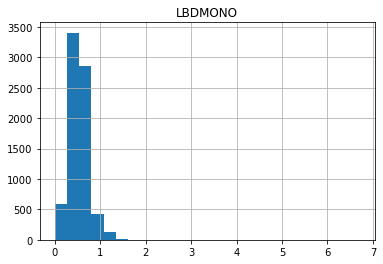

In [25]:
final_labs.hist(column='LBDMONO', bins=25)

In [26]:
#EDA on Dietary Supplements data

In [27]:
filename = "2018_supplements.csv"

In [28]:
df_supplements=spark.read.csv(filename,  inferSchema=True, header = True)

In [29]:
df_supplements.show(2)

+-------+--------+--------+------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+------+-------+-------+--------+-------+------+--------+-------+--------+------+------+------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+
|   SEQN|DSDCOUNT|DSDANCNT|DSD010|DSD010AN|DSQTKCAL|DSQTPROT|DSQTCARB|DSQTSUGR|DSQTFIBE|DSQTTFAT|DSQTSFAT|DSQTMFAT|DSQTPFAT|DSQTCHOL|DSQTLYCO|DSQTLZ|DSQTVB1|DSQTVB2|DSQTNIAC|DSQTVB6|DSQTFA|DSQTFDFE|DSQTCHL|DSQTVB12|DSQTVC|DSQTVK|DSQTVD|DSQTCALC|DSQTPHOS|DSQTMAGN|DSQTIRON|DSQTZINC|DSQTCOPP|DSQTSODI|DSQTPOTA|DSQTSELE|DSQTCAFF|DSQTIODI|
+-------+--------+--------+------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+------+-------+-------+--------+-------+------+--------+-------+--------+------+------+------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--

In [30]:
#drop columns that will not be used
dropCols=("DSQTKCAL","DSQTPROT","DSQTCARB","DSQTSUGR","DSQTFIBE","DSQTTFAT","DSQTSFAT","DSQTMFAT","DSQTPFAT","DSQTCHOL","DSQTCHL","DSQTCAFF")
df_supplements=df_supplements.drop(*dropCols)

In [31]:
df_supplements.columns

['SEQN',
 'DSDCOUNT',
 'DSDANCNT',
 'DSD010',
 'DSD010AN',
 'DSQTLYCO',
 'DSQTLZ',
 'DSQTVB1',
 'DSQTVB2',
 'DSQTNIAC',
 'DSQTVB6',
 'DSQTFA',
 'DSQTFDFE',
 'DSQTVB12',
 'DSQTVC',
 'DSQTVK',
 'DSQTVD',
 'DSQTCALC',
 'DSQTPHOS',
 'DSQTMAGN',
 'DSQTIRON',
 'DSQTZINC',
 'DSQTCOPP',
 'DSQTSODI',
 'DSQTPOTA',
 'DSQTSELE',
 'DSQTIODI']

In [32]:
df_supplements.show(2)

+-------+--------+--------+------+--------+--------+------+-------+-------+--------+-------+------+--------+--------+------+------+------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+
|   SEQN|DSDCOUNT|DSDANCNT|DSD010|DSD010AN|DSQTLYCO|DSQTLZ|DSQTVB1|DSQTVB2|DSQTNIAC|DSQTVB6|DSQTFA|DSQTFDFE|DSQTVB12|DSQTVC|DSQTVK|DSQTVD|DSQTCALC|DSQTPHOS|DSQTMAGN|DSQTIRON|DSQTZINC|DSQTCOPP|DSQTSODI|DSQTPOTA|DSQTSELE|DSQTIODI|
+-------+--------+--------+------+--------+--------+------+-------+-------+--------+-------+------+--------+--------+------+------+------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+
|93703.0|     1.0|     0.0|   1.0|       2|       0|     0|    0.0|    0.0|     0.0|    1.0|   167|     284|     3.0|  20.0|   0.0|   7.5|     0.0|     0.0|     0.0|     0.0|    1.35|     0.0|     0.0|     0.0|     0.0|    21.0|
|93704.0|     0.0|     0.0|   2.0|       2|       0|     0|    0.0|    0.0|     0.0|

In [33]:
#Get row count and distinct rows count
print(f'Count of rows:{df_supplements.count()}')
print(f'Count of distinct rows:{df_supplements.distinct().count()}')


Count of rows:9300
Count of distinct rows:9255


In [34]:
#delete duplicates
df_supplements=df_supplements.dropDuplicates()

In [35]:
#delete row with bad data
df_supplements=df_supplements.where("SEQN>1")

In [36]:
#Updated row count and distinct rows count

print(f'Count of rows:{df_supplements.count()}')
print(f'Count of disctinct rows:{df_supplements.distinct().count()}')

Count of rows:9254
Count of disctinct rows:9254


In [37]:
#Number of columns
print(f'Count of columns:{len(df_supplements.columns)}')


Count of columns:27


In [38]:
#Descriptive statisticts on some predictor variables
desc_supplements=df_supplements.describe(['DSQTNIAC','DSD010AN','DSQTLYCO'])

In [39]:
#convert supplements to pandas
df_supplements = df_supplements.toPandas()


In [40]:
df_supplements.describe()

,SEQN,DSDCOUNT,DSDANCNT,DSD010,DSD010AN,DSQTLYCO,DSQTLZ,DSQTVB1,DSQTVB2,DSQTNIAC,...,DSQTCALC,DSQTPHOS,DSQTMAGN,DSQTIRON,DSQTZINC,DSQTCOPP,DSQTSODI,DSQTPOTA,DSQTSELE,DSQTIODI
count,9254.000000,9254.000000,9254.000000,9254.000000,9254.000000,9254.000000,9254.000000,9254.000000,9254.000000,9254.000000,...,9254.000000,9254.000000,9254.000000,9254.000000,9254.000000,9254.000000,9254.000000,9254.000000,9254.000000,9254.000000
mean,98329.500000,1.062459,0.143614,1.550032,1.910741,37.749081,130.370759,1.609584,1.055003,4.882905,...,71.854936,2.955162,16.418875,2.328525,2.406228,0.152068,1.678647,8.653152,6.684596,19.587855
std,2671.544029,3.154988,2.130259,0.536200,0.325486,447.310995,1456.294804,10.711743,7.570906,31.587021,...,221.968504,20.148543,79.354650,11.007427,8.788139,0.492060,20.399114,86.958049,32.930787,155.927544
min,93703.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,96016.250000,0.000000,0.000000,1.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,98329.500000,0.000000,0.000000,2.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,100642.750000,1.000000,0.000000,2.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,7.330000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,102956.000000,99.000000,99.000000,9.000000,9.000000,30000.000000,48000.000000,251.500000,401.700000,1520.000000,...,3750.000000,1200.000000,3390.000000,260.000000,450.000000,6.100000,1500.000000,6750.000000,2100.000000,12500.000000


<AxesSubplot:>

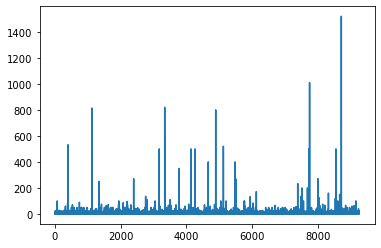

In [41]:
df_supplements["DSQTNIAC"].plot()

<AxesSubplot:>

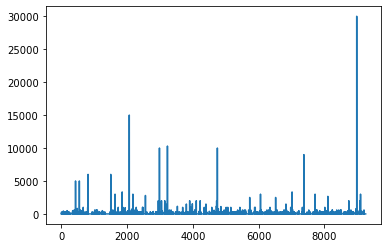

In [42]:
df_supplements["DSQTLYCO"].plot()

In [43]:
#identifying categorical variables from supplements dataset
sup_cat=['DSD010','DSD010AN']

In [44]:
#Medical Questionnaire Dataset

mcq = 'MCQ_J.csv'
df_mcq = pd.read_csv(mcq)
df_mcq['SEQN'] = pd.to_numeric(df_mcq['SEQN'], downcast='integer')

In [45]:
df_mcq['SEQN'].count()

8900

In [46]:
df_mcq = spark.createDataFrame(df_mcq)

to_drop = ('MCQ010','MCD093','MCQ149','MCQ151','RHD018','MCQ180N','MCQ180A','MCD180D',
           'MCD180E','MCD180F','MCD180M','MCD180G','MCQ160K','MCD180K','MCD180L',
           'MCQ515','MCQ570','MCQ106','MCD240A','MCD240B','MCD240C','MCQ230D','MCD180C',
           'MCQ300B','AGQ030', 'OS230', 'MCD180A', 'MCD180N', 'MCD180B', 'MCQ206')

df_mcq = df_mcq.drop(*to_drop)
#dropping unnecessary columns

In [47]:
df_mcq.columns

['SEQN',
 'MCQ025',
 'MCQ035',
 'MCQ040',
 'MCQ050',
 'MCQ053',
 'MCQ080',
 'MCQ092',
 'MCQ160A',
 'MCQ195',
 'MCQ160N',
 'MCQ160B',
 'MCQ160C',
 'MCQ160D',
 'MCQ160E',
 'MCQ160F',
 'MCQ160M',
 'MCQ170M',
 'MCQ160G',
 'MCQ170K',
 'MCQ160O',
 'MCQ160L',
 'MCQ170L',
 'MCQ500',
 'MCQ510A',
 'MCQ510B',
 'MCQ510C',
 'MCQ510D',
 'MCQ510E',
 'MCQ510F',
 'MCQ520',
 'MCQ530',
 'MCQ540',
 'MCQ550',
 'MCQ560',
 'MCQ203',
 'MCQ220',
 'MCQ230A',
 'MCQ230B',
 'MCQ230C',
 'MCQ300C',
 'MCQ300A',
 'MCQ366A',
 'MCQ366B',
 'MCQ366C',
 'MCQ366D',
 'MCQ371A',
 'MCQ371B',
 'MCQ371C',
 'MCQ371D',
 'OSQ230']

In [48]:
#convert mcq to pandas
df_mcq = df_mcq.toPandas()

In [49]:
#identifying categorical variables from the medical questionnaire data

mcq_cat = [x for x in df_mcq.columns if x!='SEQN']
#these are all categorical variables except SEQN, which is the identifier

In [50]:
#Demographics Dataset

demo = 'DEMO_J.csv'
df_demo = pd.read_csv(demo)
df_demo['SEQN'] = pd.to_numeric(df_demo['SEQN'], downcast='integer')

In [51]:
df_demo = df_demo[['SEQN', 'RIAGENDR', 'RIDAGEYR', 'RIDRETH3','DMQMILIZ', 
            'DMQADFC', 'DMDBORN4', 'DMDCITZN', 'DMDEDUC3', 'DMDEDUC2', 
            'DMDMARTL', 'RIDEXPRG', 'DMDHHSIZ', 'DMDFMSIZ','INDFMPIR']]

#keeping only relevant columns

In [52]:
#Identifying categorical variables from demographics dataset
demo_cat = ['RIAGENDR','RIDRETH3', 'DMQMILIZ', 'DMQADFC', 'DMDBORN4', 
                        'DMDCITZN', 'DMDEDUC3', 'DMDEDUC2', 'DMDMARTL', 'RIDEXPRG']

In [53]:
df_demo.head()

,SEQN,RIAGENDR,RIDAGEYR,RIDRETH3,DMQMILIZ,DMQADFC,DMDBORN4,DMDCITZN,DMDEDUC3,DMDEDUC2,DMDMARTL,RIDEXPRG,DMDHHSIZ,DMDFMSIZ,INDFMPIR
0,93703,2.0,2.0,6,0,0,1,1,0,0,0,0,5,5,5.00
1,93704,1.0,2.0,3,0,0,1,1,0,0,0,0,4,4,5.00
2,93705,2.0,66.0,4,2,0,1,1,0,2,3,0,1,1,0.82
3,93706,1.0,18.0,6,2,0,1,1,15,0,0,0,5,5,0.00
4,93707,1.0,13.0,7,0,0,1,1,6,0,0,0,7,7,1.88


In [54]:
#Diertary Dataset
df_diet_day1=spark.read.csv('dr1tot.csv',  inferSchema=True, header = True)
df_diet_day2=spark.read.csv('dr2tot.csv', inferSchema=True, header=True)

In [55]:
df_diet_day2.count()

8800

In [56]:
#columns to drop
drops=[x for x in df_diet_day1.columns if x not in ['SEQN',"DR1DRSTZ","DRQSPREP",'DR1TPROT','DR1TCARB','DR1TSUGR','DR1TFIBE','DR1TTFAT','DR1TSFAT','DR1TMFAT','DR1TPFAT','DR1TCHOL','DR1TATOC','DR1TATOA','DR1TRET','DR1TVARA','DR1TACAR','DR1TBCAR','DR1TCRYP','DR1TLYCO','DR1TLZ','DR1TVB1','DR1TVB2','DR1TNIAC','DR1TVB6','DR1TFOLA','DR1TFA','DR1TFF','DR1TFDFE','DR1TCHL','DR1TVB12','DR1TB12A','DR1TVC','DR1TVD','DR1TVK','DR1TCALC','DR1TPHOS','DR1TMAGN','DR1TIRON','DR1TZINC','DR1TCOPP','DR1TSODI','DR1TPOTA','DR1TSELE','DR1TCAFF','DR1TTHEO','DR1TALCO','DR1_300']]

In [57]:
#dropping unnecessary columns
df_diet=df_diet_day1.drop(*drops)

In [58]:
#delete duplicates
df_diet=df_diet.dropDuplicates()

#delete row with bad data
df_diet=df_diet.where("SEQN>1")

In [59]:
df_diet.show(2)

+-------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+-------+--------+--------+--------+--------+--------+------+-------+-------+--------+-------+--------+------+------+--------+-------+--------+--------+------+------+------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+-------+
|   SEQN|DR1DRSTZ|DRQSPREP|DR1TPROT|DR1TCARB|DR1TSUGR|DR1TFIBE|DR1TTFAT|DR1TSFAT|DR1TMFAT|DR1TPFAT|DR1TCHOL|DR1TATOC|DR1TATOA|DR1TRET|DR1TVARA|DR1TACAR|DR1TBCAR|DR1TCRYP|DR1TLYCO|DR1TLZ|DR1TVB1|DR1TVB2|DR1TNIAC|DR1TVB6|DR1TFOLA|DR1TFA|DR1TFF|DR1TFDFE|DR1TCHL|DR1TVB12|DR1TB12A|DR1TVC|DR1TVD|DR1TVK|DR1TCALC|DR1TPHOS|DR1TMAGN|DR1TIRON|DR1TZINC|DR1TCOPP|DR1TSODI|DR1TPOTA|DR1TSELE|DR1TCAFF|DR1TTHEO|DR1TALCO|DR1_300|
+-------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+-------+--------+--------+--------+--------+

In [60]:
#Get row count and distinct rows count
print(f'Count of rows:{df_diet.count()}')
print(f'Count of distinct rows:{df_diet.distinct().count()}')

Count of rows:8704
Count of distinct rows:8704


In [61]:
#drop rows with no relieable nutrition information (i.e only keep rows where DR1DRSTZ==1)
df_diet_final=df_diet.where(df_diet.DR1DRSTZ==1)

In [62]:
#Identifying categorical variables from diet dataset
diet_cat=['DR1DRSTZ','DRQSPREP','DR1_300']

In [63]:
#Get row count and distinct rows count
print(f'Count of rows:{df_diet_final.count()}')
print(f'Count of distinct rows:{df_diet_final.distinct().count()}')

Count of rows:7484
Count of distinct rows:7484


In [64]:
df_diet_final.columns

['SEQN',
 'DR1DRSTZ',
 'DRQSPREP',
 'DR1TPROT',
 'DR1TCARB',
 'DR1TSUGR',
 'DR1TFIBE',
 'DR1TTFAT',
 'DR1TSFAT',
 'DR1TMFAT',
 'DR1TPFAT',
 'DR1TCHOL',
 'DR1TATOC',
 'DR1TATOA',
 'DR1TRET',
 'DR1TVARA',
 'DR1TACAR',
 'DR1TBCAR',
 'DR1TCRYP',
 'DR1TLYCO',
 'DR1TLZ',
 'DR1TVB1',
 'DR1TVB2',
 'DR1TNIAC',
 'DR1TVB6',
 'DR1TFOLA',
 'DR1TFA',
 'DR1TFF',
 'DR1TFDFE',
 'DR1TCHL',
 'DR1TVB12',
 'DR1TB12A',
 'DR1TVC',
 'DR1TVD',
 'DR1TVK',
 'DR1TCALC',
 'DR1TPHOS',
 'DR1TMAGN',
 'DR1TIRON',
 'DR1TZINC',
 'DR1TCOPP',
 'DR1TSODI',
 'DR1TPOTA',
 'DR1TSELE',
 'DR1TCAFF',
 'DR1TTHEO',
 'DR1TALCO',
 'DR1_300']

In [65]:
#convert diet df to pandas
df_diet_pd=df_diet_final.toPandas()

In [66]:
#descriptive statistics on diet dataset
df_diet_pd.describe()

,SEQN,DR1DRSTZ,DRQSPREP,DR1TPROT,DR1TCARB,DR1TSUGR,DR1TFIBE,DR1TTFAT,DR1TSFAT,DR1TMFAT,...,DR1TIRON,DR1TZINC,DR1TCOPP,DR1TSODI,DR1TPOTA,DR1TSELE,DR1TCAFF,DR1TTHEO,DR1TALCO,DR1_300
count,7484.000000,7484.0,7484.000000,7484.000000,7484.000000,7484.000000,7484.000000,7484.000000,7484.000000,7484.000000,...,7484.000000,7484.000000,7484.000000,7484.000000,7484.000000,7484.000000,7484.000000,7484.000000,7484.000000,7484.000000
mean,98328.898584,1.0,3.132282,72.741741,240.028939,105.706275,15.333151,79.765715,26.260014,27.047642,...,13.617913,10.070481,1.060954,3167.725414,2352.873463,102.949051,100.250267,36.899118,5.848530,2.121325
std,2669.681287,0.0,1.170203,41.547915,124.659625,72.516870,10.295339,47.295875,16.969165,17.064877,...,8.452313,8.509530,0.794364,1867.411866,1232.486454,70.996850,184.316186,76.045445,22.082343,0.657184
min,93704.000000,1.0,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,96009.500000,1.0,2.000000,44.800000,156.682500,58.127500,8.300000,46.850000,14.700500,15.334750,...,8.060000,5.860000,0.629000,1920.500000,1507.000000,60.675000,1.000000,0.000000,0.000000,2.000000
50%,98351.500000,1.0,3.000000,65.135000,219.045000,90.755000,13.100000,70.420000,22.744000,23.592000,...,11.850000,8.600000,0.916500,2816.000000,2142.000000,90.300000,35.000000,0.000000,0.000000,2.000000
75%,100628.250000,1.0,4.000000,91.782500,299.100000,134.875000,19.725000,101.502500,33.979750,34.881000,...,16.972500,12.530000,1.307000,4026.750000,2962.000000,129.400000,143.000000,46.000000,0.000000,2.000000
max,102956.000000,1.0,9.000000,545.200000,1476.760000,931.160000,107.800000,567.960000,195.852000,200.097000,...,111.040000,477.530000,36.816000,25949.000000,14358.000000,2604.900000,4320.000000,1188.000000,406.800000,9.000000


In [67]:
df_diet_pd.head(5)

,SEQN,DR1DRSTZ,DRQSPREP,DR1TPROT,DR1TCARB,DR1TSUGR,DR1TFIBE,DR1TTFAT,DR1TSFAT,DR1TMFAT,...,DR1TIRON,DR1TZINC,DR1TCOPP,DR1TSODI,DR1TPOTA,DR1TSELE,DR1TCAFF,DR1TTHEO,DR1TALCO,DR1_300
0,94078.0,1.0,4,37.03,247.14,162.70,8.5,60.48,19.946,22.965,...,6.92,5.67,0.746,2642,2214,37.7,142,115,0.0,2
1,94155.0,1.0,4,39.88,183.70,72.92,24.1,89.96,14.635,32.490,...,11.37,6.85,1.645,1566,2461,102.4,102,0,0.0,2
2,94376.0,1.0,3,91.41,653.09,321.77,22.4,168.99,51.487,50.795,...,24.98,11.49,1.693,5092,5181,101.0,890,10,0.0,2
3,94588.0,1.0,1,55.96,187.40,114.64,6.0,67.71,31.900,21.194,...,6.43,6.47,0.400,1707,1621,79.1,0,0,0.0,2
4,94602.0,1.0,4,56.48,281.33,148.45,9.5,74.89,23.447,22.184,...,9.60,6.51,0.713,2320,2189,54.8,5,84,0.0,2


In [68]:
#merge labs, demograpgics, mcq, and Diet dataframes
nhanes1=df_merge_col = pd.merge(final_labs, df_supplements,on='SEQN')
nhanes2=df_merge_col = pd.merge(nhanes1, df_demo,on='SEQN')
nhanes3=df_merge_col = pd.merge(nhanes2, df_diet_pd,on='SEQN')
final_nhanes=df_merge_col = pd.merge(nhanes3, df_mcq,on='SEQN')

In [69]:
final_nhanes.head(2)

,SEQN,LBDLYMNO,LBDMONO,LBDEONO,LBDBANO,LBXHCT,LBXMCHSI,LBXPLTSI,LBXNRBC,LBXHSCRP,...,MCQ300A,MCQ366A,MCQ366B,MCQ366C,MCQ366D,MCQ371A,MCQ371B,MCQ371C,MCQ371D,OSQ230
0,93705,3.4,0.6,0.2,0.1,36.7,21.7,309,0.0,2.72,...,2,2,2,2,2,1,1,1,1,2
1,93706,1.5,0.6,0.3,0.0,47.0,31.1,233,0.0,0.74,...,0,2,2,2,2,2,2,2,2,0


In [70]:
#Count NAs
for x in final_nhanes.columns:
    y= final_nhanes[x].isna().sum().sum()
    print (x,y)

SEQN 0
LBDLYMNO 0
LBDMONO 0
LBDEONO 0
LBDBANO 0
LBXHCT 0
LBXMCHSI 0
LBXPLTSI 0
LBXNRBC 0
LBXHSCRP 0
LBDTCSI 0
LBDLDNSI 3827
LBDINSI 3827
DSDCOUNT 0
DSDANCNT 0
DSD010 0
DSD010AN 0
DSQTLYCO 0
DSQTLZ 0
DSQTVB1 0
DSQTVB2 0
DSQTNIAC 0
DSQTVB6 0
DSQTFA 0
DSQTFDFE 0
DSQTVB12 0
DSQTVC 0
DSQTVK 0
DSQTVD 0
DSQTCALC 0
DSQTPHOS 0
DSQTMAGN 0
DSQTIRON 0
DSQTZINC 0
DSQTCOPP 0
DSQTSODI 0
DSQTPOTA 0
DSQTSELE 0
DSQTIODI 0
RIAGENDR 0
RIDAGEYR 0
RIDRETH3 0
DMQMILIZ 0
DMQADFC 0
DMDBORN4 0
DMDCITZN 0
DMDEDUC3 0
DMDEDUC2 0
DMDMARTL 0
RIDEXPRG 0
DMDHHSIZ 0
DMDFMSIZ 0
INDFMPIR 0
DR1DRSTZ 0
DRQSPREP 0
DR1TPROT 0
DR1TCARB 0
DR1TSUGR 0
DR1TFIBE 0
DR1TTFAT 0
DR1TSFAT 0
DR1TMFAT 0
DR1TPFAT 0
DR1TCHOL 0
DR1TATOC 0
DR1TATOA 0
DR1TRET 0
DR1TVARA 0
DR1TACAR 0
DR1TBCAR 0
DR1TCRYP 0
DR1TLYCO 0
DR1TLZ 0
DR1TVB1 0
DR1TVB2 0
DR1TNIAC 0
DR1TVB6 0
DR1TFOLA 0
DR1TFA 0
DR1TFF 0
DR1TFDFE 0
DR1TCHL 0
DR1TVB12 0
DR1TB12A 0
DR1TVC 0
DR1TVD 0
DR1TVK 0
DR1TCALC 0
DR1TPHOS 0
DR1TMAGN 0
DR1TIRON 0
DR1TZINC 0
DR1TCOPP 0
DR1TSODI 0
DR1TP

In [71]:
final_nhanes.shape

(6582, 150)

In [72]:
#drop anyone under the age of 12
#this is due to some relevant variables not being collected for participants under 12

final_nhanes_over11=final_nhanes[final_nhanes['RIDAGEYR']>11]
final_nhanes_over11.shape

(5787, 150)

## Data Preprocessing

### Missing Data: Imputing Mean Values for LDL and Insulin

In [73]:
#Dataframe with the mean of LDL and Insulin by Gender and Age
LDL_INS_MEAN = final_nhanes_over11.groupby(['RIAGENDR','RIDAGEYR']).agg({'LBDLDNSI': ['mean'],'LBDINSI': ['mean']})
LDL_INS_MEAN.columns = ['LDL_mean','INS_mean']
LDL_INS_MEAN = LDL_INS_MEAN.reset_index()
LDL_INS_MEAN.head(7)


,RIAGENDR,RIDAGEYR,LDL_mean,INS_mean
0,1.0,12.0,2.329905,63.754286
1,1.0,13.0,1.621625,60.910000
2,1.0,14.0,2.126462,81.996923
3,1.0,15.0,1.793211,58.294737
4,1.0,16.0,1.971500,63.836842
5,1.0,17.0,2.118417,75.400000
6,1.0,18.0,2.083500,94.279286


In [74]:
#add the LDL_Mean and INS_mean to the nhanes dataframe
final_nhanes_over11= pd.merge(final_nhanes_over11, LDL_INS_MEAN,how="left",on=["RIAGENDR",'RIDAGEYR'])


In [75]:
#check if LDL_mean and INS_mean are in the dataframe
final_nhanes_over11[["SEQN","RIAGENDR","RIDAGEYR",'LDL_mean',"INS_mean"]].head()

,SEQN,RIAGENDR,RIDAGEYR,LDL_mean,INS_mean
0,93705,2.0,66.0,2.943125,82.305000
1,93706,1.0,18.0,2.083500,94.279286
2,93707,1.0,13.0,1.621625,60.910000
3,93708,2.0,66.0,2.943125,82.305000
4,93711,1.0,56.0,2.875600,56.676000


In [76]:
#fill LBDLDNSI with means
final_nhanes_over11['LBDLDNSI'].fillna(final_nhanes_over11['LDL_mean'], inplace=True)

#fill LBDINSI with means
final_nhanes_over11['LBDINSI'].fillna(final_nhanes_over11['INS_mean'], inplace=True)

In [77]:
#check if anymore NAs in column
final_nhanes_over11['LBDLDNSI'].isna().sum().sum()

#check if anymore NAs in column
final_nhanes_over11['LBDINSI'].isna().sum().sum()

0

In [78]:
final_nhanes_over11.shape

(5787, 152)

In [79]:
#create list of all categorical variables
cat_variables=demo_cat+sup_cat+diet_cat+mcq_cat

In [80]:
#create spark dataframe
final_nhanes_over11 = spark.createDataFrame(final_nhanes_over11)

### Missing Data: Removing "Don't Know"/"Unsure" Answers

In [81]:
#finding counts of rows with null values 77777 and 99999 in medical questionnaires

from pyspark.sql.functions import *
rows = final_nhanes_over11.select([count(when(col(c).isin(77777, 99999), c)).alias(c) for c in final_nhanes_over11.columns]) 
rows.show() 

#very few of these, should be replaced with NAs

+----+--------+-------+-------+-------+------+--------+--------+-------+--------+-------+--------+-------+--------+--------+------+--------+--------+------+-------+-------+--------+-------+------+--------+--------+------+------+------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+-------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+-------+--------+--------+--------+--------+--------+------+-------+-------+--------+-------+--------+------+------+--------+-------+--------+--------+------+------+------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+-------+------+------+------+------+------+------+------+-------+------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-

In [82]:
#replacing 77777/99999 (missing/don't know) with Null
final_nhanes_over11 = (final_nhanes_over11.replace(77777, None)).replace(99999,None)

In [83]:
#drop nas
final_nhanes_over11 = final_nhanes_over11.dropna()

In [84]:
#checking results
rows = final_nhanes_over11.select([count(when(col(c).isin(77777, 99999), c)).alias(c) for c in final_nhanes_over11.columns]) 
rows.show() 

#all 0s!

+----+--------+-------+-------+-------+------+--------+--------+-------+--------+-------+--------+-------+--------+--------+------+--------+--------+------+-------+-------+--------+-------+------+--------+--------+------+------+------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+-------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+-------+--------+--------+--------+--------+--------+------+-------+-------+--------+-------+--------+------+------+--------+-------+--------+--------+------+------+------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+-------+------+------+------+------+------+------+------+-------+------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-

### Feature Engineering: Creating Label column based on Medical Questionnaire Data

In [85]:
#add a label column with value 1 for anyone with heart disease
from pyspark.sql.functions import when

final_nhanes_over_mod = final_nhanes_over11.withColumn(
    "label", when(final_nhanes_over11.MCQ160B == 1,"1"
                 )\
    .when(final_nhanes_over11.MCQ160C == 1,1)\
    .when(final_nhanes_over11.MCQ160D == 1,1)\
    .when(final_nhanes_over11.MCQ160E == 1,1)\
    .when(final_nhanes_over11.MCQ160F == 1,1)\
    .when(final_nhanes_over11.MCQ160O == 1,1)\
    .otherwise(0)) 

#if ever told had congestive heart failure, COPD, angina/angina pectoris, heart attack, or stroke, label = 1
#if none of the above, label = 0

In [86]:
final_nhanes_over_mod.select('MCQ160C','MCQ160D','MCQ160E','MCQ160F','MCQ160O','label').show(10)
#if any of these columns = 1, then label should also = 1

+-------+-------+-------+-------+-------+-----+
|MCQ160C|MCQ160D|MCQ160E|MCQ160F|MCQ160O|label|
+-------+-------+-------+-------+-------+-----+
|      2|      2|      2|      2|      2|    0|
|      0|      0|      0|      0|      0|    0|
|      0|      0|      0|      0|      0|    0|
|      2|      2|      2|      2|      2|    0|
|      2|      2|      2|      2|      2|    0|
|      0|      0|      0|      0|      0|    0|
|      2|      2|      2|      2|      2|    0|
|      2|      2|      2|      2|      2|    0|
|      2|      2|      2|      2|      1|    1|
|      2|      2|      2|      2|      2|    0|
+-------+-------+-------+-------+-------+-----+
only showing top 10 rows



In [87]:
heartCols = ('MCD180B', 'MCQ160C', 'MCQ160D', 'MCQ160E', 'MCQ160F', 'MCQ160O')

In [88]:
#removing heart disease columns from categorical variable list
for ele in cat_variables:
    if ele in heartCols:
        cat_variables.remove(ele)

In [89]:
cat_variables=[x for x in cat_variables if x not in heartCols]

In [90]:
final_nhanes_over_mod=final_nhanes_over_mod.drop(*heartCols)
#removing columns from feature engineering from the dataset

### Feature Engineering/Pipeline: One-Hot Encoding Categorical Variables

In [91]:
#apply one hot encoding to all categorical variables
from pyspark.ml import Pipeline
from pyspark.ml.feature import OneHotEncoder
from pyspark.ml.linalg import Vectors

stage_one_hot = [OneHotEncoder(inputCol= c, outputCol= c+ "_one_hot") for c in cat_variables]

ppl = Pipeline(stages= stage_one_hot)
final_nhanes_over11_encoded = ppl.fit(final_nhanes_over_mod).transform(final_nhanes_over_mod)

In [92]:
final_nhanes_over11_encoded=final_nhanes_over11_encoded.drop(*cat_variables)


In [93]:
final_nhanes_over11_encoded.select(["RIAGENDR_one_hot","RIDRETH3_one_hot"]).show(10)

+----------------+----------------+
|RIAGENDR_one_hot|RIDRETH3_one_hot|
+----------------+----------------+
|       (2,[],[])|   (7,[4],[1.0])|
|   (2,[1],[1.0])|   (7,[6],[1.0])|
|   (2,[1],[1.0])|       (7,[],[])|
|       (2,[],[])|   (7,[6],[1.0])|
|   (2,[1],[1.0])|   (7,[6],[1.0])|
|   (2,[1],[1.0])|   (7,[1],[1.0])|
|   (2,[1],[1.0])|   (7,[3],[1.0])|
|       (2,[],[])|   (7,[4],[1.0])|
|   (2,[1],[1.0])|       (7,[],[])|
|   (2,[1],[1.0])|   (7,[6],[1.0])|
+----------------+----------------+
only showing top 10 rows



In [94]:
#convert label to DoubleType format
from pyspark.sql.types import DoubleType
final_nhanes_over11_encoded = final_nhanes_over11_encoded.withColumn("label", final_nhanes_over11_encoded.label.cast(DoubleType()))


In [95]:
final_nhanes_over11_encoded.select("label").show(10)

+-----+
|label|
+-----+
|  0.0|
|  0.0|
|  0.0|
|  0.0|
|  0.0|
|  0.0|
|  0.0|
|  0.0|
|  1.0|
|  0.0|
+-----+
only showing top 10 rows



### Feature Engineering: Creating Features Column using VectorAssembler

In [96]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.feature import StandardScaler

In [97]:
final_nhanes_over11_encoded.columns

['SEQN',
 'LBDLYMNO',
 'LBDMONO',
 'LBDEONO',
 'LBDBANO',
 'LBXHCT',
 'LBXMCHSI',
 'LBXPLTSI',
 'LBXNRBC',
 'LBXHSCRP',
 'LBDTCSI',
 'LBDLDNSI',
 'LBDINSI',
 'DSDCOUNT',
 'DSDANCNT',
 'DSQTLYCO',
 'DSQTLZ',
 'DSQTVB1',
 'DSQTVB2',
 'DSQTNIAC',
 'DSQTVB6',
 'DSQTFA',
 'DSQTFDFE',
 'DSQTVB12',
 'DSQTVC',
 'DSQTVK',
 'DSQTVD',
 'DSQTCALC',
 'DSQTPHOS',
 'DSQTMAGN',
 'DSQTIRON',
 'DSQTZINC',
 'DSQTCOPP',
 'DSQTSODI',
 'DSQTPOTA',
 'DSQTSELE',
 'DSQTIODI',
 'RIDAGEYR',
 'DMDHHSIZ',
 'DMDFMSIZ',
 'INDFMPIR',
 'DR1TPROT',
 'DR1TCARB',
 'DR1TSUGR',
 'DR1TFIBE',
 'DR1TTFAT',
 'DR1TSFAT',
 'DR1TMFAT',
 'DR1TPFAT',
 'DR1TCHOL',
 'DR1TATOC',
 'DR1TATOA',
 'DR1TRET',
 'DR1TVARA',
 'DR1TACAR',
 'DR1TBCAR',
 'DR1TCRYP',
 'DR1TLYCO',
 'DR1TLZ',
 'DR1TVB1',
 'DR1TVB2',
 'DR1TNIAC',
 'DR1TVB6',
 'DR1TFOLA',
 'DR1TFA',
 'DR1TFF',
 'DR1TFDFE',
 'DR1TCHL',
 'DR1TVB12',
 'DR1TB12A',
 'DR1TVC',
 'DR1TVD',
 'DR1TVK',
 'DR1TCALC',
 'DR1TPHOS',
 'DR1TMAGN',
 'DR1TIRON',
 'DR1TZINC',
 'DR1TCOPP',
 'DR1TSODI',
 '

In [98]:
#select all coloumns from dataframes for independent variable
ind_vars = [x for x in final_nhanes_over11_encoded.columns if x not in 'SEQN' and 'label']
#independent variables include everything except participant # and label (heart disease indicator)

print(ind_vars)

['LBDLYMNO', 'LBDMONO', 'LBDEONO', 'LBDBANO', 'LBXHCT', 'LBXMCHSI', 'LBXPLTSI', 'LBXNRBC', 'LBXHSCRP', 'LBDTCSI', 'LBDLDNSI', 'LBDINSI', 'DSDCOUNT', 'DSDANCNT', 'DSQTLYCO', 'DSQTLZ', 'DSQTVB1', 'DSQTVB2', 'DSQTNIAC', 'DSQTVB6', 'DSQTFA', 'DSQTFDFE', 'DSQTVB12', 'DSQTVC', 'DSQTVK', 'DSQTVD', 'DSQTCALC', 'DSQTPHOS', 'DSQTMAGN', 'DSQTIRON', 'DSQTZINC', 'DSQTCOPP', 'DSQTSODI', 'DSQTPOTA', 'DSQTSELE', 'DSQTIODI', 'RIDAGEYR', 'DMDHHSIZ', 'DMDFMSIZ', 'INDFMPIR', 'DR1TPROT', 'DR1TCARB', 'DR1TSUGR', 'DR1TFIBE', 'DR1TTFAT', 'DR1TSFAT', 'DR1TMFAT', 'DR1TPFAT', 'DR1TCHOL', 'DR1TATOC', 'DR1TATOA', 'DR1TRET', 'DR1TVARA', 'DR1TACAR', 'DR1TBCAR', 'DR1TCRYP', 'DR1TLYCO', 'DR1TLZ', 'DR1TVB1', 'DR1TVB2', 'DR1TNIAC', 'DR1TVB6', 'DR1TFOLA', 'DR1TFA', 'DR1TFF', 'DR1TFDFE', 'DR1TCHL', 'DR1TVB12', 'DR1TB12A', 'DR1TVC', 'DR1TVD', 'DR1TVK', 'DR1TCALC', 'DR1TPHOS', 'DR1TMAGN', 'DR1TIRON', 'DR1TZINC', 'DR1TCOPP', 'DR1TSODI', 'DR1TPOTA', 'DR1TSELE', 'DR1TCAFF', 'DR1TTHEO', 'DR1TALCO', 'LDL_mean', 'INS_mean', 'labe

In [99]:
#make a list of independent variables exclude label column and columns used to come up with label
assembler=VectorAssembler(inputCols=ind_vars,outputCol="features")
nhanes_modelDf=assembler.transform(final_nhanes_over11_encoded)

In [100]:
nhanes_modelDf.select("features").show(1, truncate=False)

+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

### Feature Enginering: Scaling Numeric Variables

In [101]:
# Feature scaling
import os
os.environ['SPARK_HOME'] = "C:/Spark/spark-1.4.1-bin-hadoop2.6"
sc.setCheckpointDir('checkpoint')

# Initialize the `standardScaler`
standardScaler = StandardScaler(inputCol="features", outputCol="features_scaled", 
                                withStd=True, withMean=False)

# Fit the DataFrame to the scaler; this computes the mean, standard deviation of each feature
scaler = standardScaler.fit(nhanes_modelDf)

# Transform the data in `nhanes_modelDf` with the scaler
scaled_df = scaler.transform(nhanes_modelDf)

### Upsampling for Unbalanced Groups

In [102]:
# compute distribution of label
scaled_df.groupBy("label").count().show()


+-----+-----+
|label|count|
+-----+-----+
|  0.0| 5060|
|  1.0|  714|
+-----+-----+



In [103]:
scaled_df.cache()


DataFrame[SEQN: bigint, LBDLYMNO: double, LBDMONO: double, LBDEONO: double, LBDBANO: double, LBXHCT: double, LBXMCHSI: double, LBXPLTSI: bigint, LBXNRBC: double, LBXHSCRP: double, LBDTCSI: double, LBDLDNSI: double, LBDINSI: double, DSDCOUNT: double, DSDANCNT: double, DSQTLYCO: bigint, DSQTLZ: bigint, DSQTVB1: double, DSQTVB2: double, DSQTNIAC: double, DSQTVB6: double, DSQTFA: bigint, DSQTFDFE: bigint, DSQTVB12: double, DSQTVC: double, DSQTVK: double, DSQTVD: double, DSQTCALC: double, DSQTPHOS: double, DSQTMAGN: double, DSQTIRON: double, DSQTZINC: double, DSQTCOPP: double, DSQTSODI: double, DSQTPOTA: double, DSQTSELE: double, DSQTIODI: double, RIDAGEYR: double, DMDHHSIZ: bigint, DMDFMSIZ: bigint, INDFMPIR: double, DR1TPROT: double, DR1TCARB: double, DR1TSUGR: double, DR1TFIBE: double, DR1TTFAT: double, DR1TSFAT: double, DR1TMFAT: double, DR1TPFAT: double, DR1TCHOL: bigint, DR1TATOC: double, DR1TATOA: double, DR1TRET: bigint, DR1TVARA: bigint, DR1TACAR: bigint, DR1TBCAR: bigint, DR1TCRYP

In [104]:
#function for upsampling
def upsample(df, target, positive_label, negative_label,SEED=314):

    if df.filter(df[target] ==positive_label).count()<df.filter(df[target] ==negative_label).count():
        frac=df.filter(df[target] ==negative_label).count()/df.filter(df[target] ==positive_label).count()

        df_upsample=df.filter(df[target]==positive_label).sample(withReplacement=True,fraction=frac,seed=SEED)
        df_noUp=df.filter(df[target]==negative_label)
    elif df.filter(df[target] ==negative_label).count()<df.filter(df[target] ==positive_label).count():
        frac=df.filter(df[target] ==positive_label).count()/df.filter(df[target] ==negative_label).count()

        df_upsample=df.filter(df[target]==negative_label).sample(withReplacement=True,fraction=frac,seed=SEED)
        df_noUp=df.filter(df[target]==positive_label)
    
    df_b=df_noUp.union(df_upsample)
    
    return df_b

In [105]:
balanced_df= upsample (scaled_df, "label", 1, 0)

In [106]:
balanced_df.groupBy('label').count().show()

+-----+-----+
|label|count|
+-----+-----+
|  0.0| 5060|
|  1.0| 5157|
+-----+-----+



### Test/Train Split

In [107]:
train, test = balanced_df.randomSplit([0.7, 0.3], seed=287192)

# Modeling

## Logistic Regression

### Parameter Grid and Cross Validation

In [108]:
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import BinaryClassificationEvaluator

lr = LogisticRegression(maxIter=10)
paramGrid = ParamGridBuilder().build()

crossval = CrossValidator(estimator=lr,
                          evaluator=BinaryClassificationEvaluator(),
                          estimatorParamMaps=paramGrid,
                          numFolds=5,
                         seed=314)

cvLR = crossval.fit(train)

In [109]:
lrPred = cvLR.transform(test)
lrPred.select('label','prediction').show(5)

+-----+----------+
|label|prediction|
+-----+----------+
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
+-----+----------+
only showing top 5 rows



### Results

In [110]:
#Spark docs for regression summary
#https://spark.apache.org/docs/latest/api/python/reference/api/pyspark.ml.classification.LogisticRegressionSummary.html

from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.classification import LogisticRegression
evaluator = RegressionEvaluator(predictionCol="prediction", labelCol="label")

#getting summary
trainingSummary = cvLR.bestModel.summary

from pyspark.sql.types import StructType,StructField, StringType

mse= str(evaluator.evaluate(lrPred, {evaluator.metricName: "mse"}))
rs=str(evaluator.evaluate(lrPred, {evaluator.metricName:'r2'}))
AUROC= str(trainingSummary.areaUnderROC)

from pyspark.ml.evaluation import MulticlassClassificationEvaluator
ev = MulticlassClassificationEvaluator()

Accuracy=ev.evaluate(lrPred, {ev.metricName: "accuracy"})
Precision_HD=ev.evaluate(lrPred, {ev.metricLabel: "precisionByLabel", ev.metricLabel: 1.0})
Sensitivity_HD= ev.evaluate(lrPred, {ev.metricName: "truePositiveRateByLabel", ev.metricLabel: 1.0})
Precision_con=ev.evaluate(lrPred, {ev.metricLabel: "precisionByLabel", ev.metricLabel: 0.0})
Sensitivity_con=ev.evaluate(lrPred, {ev.metricName: "truePositiveRateByLabel", ev.metricLabel: 0.0})

# Set the model threshold to maximize F-Measure
fMeasure = trainingSummary.fMeasureByThreshold
maxFMeasure = fMeasure.groupBy().max('F-Measure').select('max(F-Measure)').head()
bestThreshold = fMeasure.where(fMeasure['F-Measure'] == maxFMeasure['max(F-Measure)']) \
    .select('threshold').head()['threshold']
lr.setThreshold(bestThreshold)

f1 = ev.evaluate(lrPred, {ev.metricName: "f1"})



In [111]:
#Logistic Regression in Summary
schema = StructType([
        StructField('Metric', StringType(), True),
        StructField('Result', StringType(), True),
])
df_summary_lr=spark.createDataFrame(schema=schema,data=[("mse", mse),("R Squared", rs),("AUROC", AUROC),
                                                        ("Accuracy", Accuracy),("Precision (heart disease)", Precision_HD),
                                                       ("Sensitivity (heart disease)", Sensitivity_HD),
                                                        ("Precision (control)", Precision_con),
                                                       ("Sensitivity (control)", Sensitivity_con),
                                                       ("F1", f1)])

df_summary_lr=df_summary_lr.select("metric",round('Result',6).alias("Logistic Regression"))


In [112]:
df_summary_lr.show(truncate=False)

+---------------------------+-------------------+
|metric                     |Logistic Regression|
+---------------------------+-------------------+
|mse                        |0.036482           |
|R Squared                  |0.854052           |
|AUROC                      |0.995205           |
|Accuracy                   |0.963518           |
|Precision (heart disease)  |0.963519           |
|Sensitivity (heart disease)|0.960077           |
|Precision (control)        |0.963519           |
|Sensitivity (control)      |0.96704            |
|F1                         |0.963519           |
+---------------------------+-------------------+



### Confusion Matrix

In [113]:
#There doesn't seem to be confusion matrix capabilities for the df version of mllib
#but there is within the multiclass metrics module for the rdd version
#so first we need to cast the predictions/label values to float, then create an rdd

from pyspark.mllib.evaluation import MulticlassMetrics
from pyspark.sql.types import FloatType
import pyspark.sql.functions as func

#ordering by prediction/casting to float for rdd
predLabels = lrPred.select(['prediction','label']).withColumn(
    'label', func.col('label'
                     ).cast(
        FloatType())
).orderBy('prediction')

#selecting only prediction and label columns
predLabels = predLabels.select(['prediction','label'])

#casting to rdd/tuple for confusion matrix
metrics = MulticlassMetrics(predLabels.rdd.map(tuple))

print(metrics.confusionMatrix().toArray())

[[1467.   50.]
 [  62. 1491.]]


## LASSO Regression

### Parameter Grid and Cross Validation

In [114]:
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import BinaryClassificationEvaluator

lr = LogisticRegression(maxIter=10)

paramGrid = ParamGridBuilder().addGrid(
    lr.regParam, [.01, 0.1, 0.3]
).addGrid(
    lr.elasticNetParam, [0] #lasso
).build()

crossval = CrossValidator(estimator=lr,
                          estimatorParamMaps=paramGrid,
                          evaluator=BinaryClassificationEvaluator(),
                          numFolds=5,
                         seed=314)

In [115]:
cvLasso = crossval.fit(train)

In [116]:
cvPred = cvLasso.transform(test)
cvPred.select('label','prediction').show(5)

+-----+----------+
|label|prediction|
+-----+----------+
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
+-----+----------+
only showing top 5 rows



### Results

In [117]:
#Spark docs for regression summary
#https://spark.apache.org/docs/latest/api/python/reference/api/pyspark.ml.classification.LogisticRegressionSummary.html

print('-'*20)
print("Best Model Hyperparameters")
print("Regularization Parameter: ", cvLasso.bestModel.getRegParam())

#getting summary
trainingSummary = cvLasso.bestModel.summary

from pyspark.sql.types import StructType,StructField, StringType

mse= str(evaluator.evaluate(cvPred, {evaluator.metricName: "mse"}))
rs=str(evaluator.evaluate(cvPred, {evaluator.metricName:'r2'}))
AUROC= str(trainingSummary.areaUnderROC)

from pyspark.ml.evaluation import MulticlassClassificationEvaluator
ev = MulticlassClassificationEvaluator()

Accuracy=ev.evaluate(cvPred, {ev.metricName: "accuracy"})
Precision_HD=ev.evaluate(cvPred, {ev.metricLabel: "precisionByLabel", ev.metricLabel: 1.0})
Sensitivity_HD= ev.evaluate(cvPred, {ev.metricName: "truePositiveRateByLabel", ev.metricLabel: 1.0})
Precision_con=ev.evaluate(cvPred, {ev.metricLabel: "precisionByLabel", ev.metricLabel: 0.0})
Sensitivity_con=ev.evaluate(cvPred, {ev.metricName: "truePositiveRateByLabel", ev.metricLabel: 0.0})

# Set the model threshold to maximize F-Measure
fMeasure = trainingSummary.fMeasureByThreshold
maxFMeasure = fMeasure.groupBy().max('F-Measure').select('max(F-Measure)').head()
bestThreshold = fMeasure.where(fMeasure['F-Measure'] == maxFMeasure['max(F-Measure)']) \
    .select('threshold').head()['threshold']
lr.setThreshold(bestThreshold)

f1 = ev.evaluate(cvPred, {ev.metricName: "f1"})


--------------------
Best Model Hyperparameters
Regularization Parameter:  0.1


In [118]:
#Lasso Logistic Regression in Summary
schema = StructType([
        StructField('Metric', StringType(), True),
        StructField('Result', StringType(), True),
])
df_summary_lasso=spark.createDataFrame(schema=schema,data=[("mse", mse),("R Squared", rs),("AUROC", AUROC),
                                                        ("Accuracy", Accuracy),("Precision (heart disease)", Precision_HD),
                                                       ("Sensitivity (heart disease)", Sensitivity_HD),
                                                        ("Precision (control)", Precision_con),
                                                       ("Sensitivity (control)", Sensitivity_con),
                                                       ("F1", f1)])

df_summary_lasso=df_summary_lasso.select("metric",round('Result',6).alias("LR-Lasso"))
df_summary_lasso.show(truncate=False)


+---------------------------+--------+
|metric                     |LR-Lasso|
+---------------------------+--------+
|mse                        |0.016612|
|R Squared                  |0.933541|
|AUROC                      |0.999559|
|Accuracy                   |0.983388|
|Precision (heart disease)  |0.983384|
|Sensitivity (heart disease)|0.992917|
|Precision (control)        |0.983384|
|Sensitivity (control)      |0.973632|
|F1                         |0.983384|
+---------------------------+--------+



### Confusion Matrix

In [119]:
#There doesn't seem to be confusion matrix capabilities for the df version of mllib
#but there is within the multiclass metrics module for the rdd version
#so first we need to cast the predictions/label values to float, then create an rdd

from pyspark.mllib.evaluation import MulticlassMetrics
from pyspark.sql.types import FloatType
import pyspark.sql.functions as func

#ordering by prediction/casting to float for rdd
predLabels = cvPred.select(['prediction','label']).withColumn(
    'label', func.col('label'
                     ).cast(
        FloatType())
).orderBy('prediction')

#selecting only prediction and label columns
predLabels = predLabels.select(['prediction','label'])

#casting to rdd/tuple for confusion matrix
metrics = MulticlassMetrics(predLabels.rdd.map(tuple))

print(metrics.confusionMatrix().toArray())

[[1477.   40.]
 [  11. 1542.]]


## Random Forest

### Parameter Grid and Cross-Validation

In [169]:
#Spark Docs
#https://spark.apache.org/docs/latest/ml-classification-regression.html#random-forest-classifier

from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.regression import RandomForestRegressor
from pyspark.ml.evaluation import RegressionEvaluator

rf = RandomForestClassifier(labelCol="label", featuresCol="features")
evaluator = RegressionEvaluator(predictionCol="prediction", labelCol="label", metricName="r2")

paramGrid = ParamGridBuilder().addGrid(rf.maxDepth, [5, 7, 10]).addGrid(rf.numTrees, [50, 100, 300]).build()

cvForest = CrossValidator(estimator=rf,
                          estimatorParamMaps=paramGrid,
                          evaluator=evaluator,
                          numFolds=5
                          )
cvForest.setSeed(314)

CrossValidator_b374d3bd4ab5

In [170]:
RF_mod = cvForest.fit(train)
print(RF_mod)

CrossValidatorModel_7061a0f5c027


In [171]:
rfPreds = RF_mod.transform(test)

### Results

In [172]:
print('-'*20)
print("Best Model Hyperparameters")
print("Number of Trees: " + str(RF_mod.bestModel.getNumTrees))
print("Max Node Depth: " + str(RF_mod.bestModel.getOrDefault('maxDepth')))

from pyspark.ml.evaluation import MulticlassClassificationEvaluator
ev = MulticlassClassificationEvaluator()
evaluator = BinaryClassificationEvaluator()

--------------------
Best Model Hyperparameters
Number of Trees: 300
Max Node Depth: 10


In [173]:
#mse= evaluator.evaluate(rfPreds, {evaluator.metricName: "mse"})
#rs=evaluator.evaluate(rfPreds)
AUROC= evaluator.evaluate(rfPreds, {evaluator.metricName: "areaUnderROC"})
Accuracy=ev.evaluate(rfPreds, {ev.metricName: "accuracy"})
Precision_HD=ev.evaluate(rfPreds, {ev.metricLabel: "precisionByLabel", ev.metricLabel: 1.0})
Sensitivity_HD= ev.evaluate(rfPreds, {ev.metricName: "truePositiveRateByLabel", ev.metricLabel: 1.0})
Precision_con=ev.evaluate(rfPreds, {ev.metricLabel: "precisionByLabel", ev.metricLabel: 0.0})
Sensitivity_con=ev.evaluate(rfPreds, {ev.metricName: "truePositiveRateByLabel", ev.metricLabel: 0.0})


f1 = ev.evaluate(rfPreds, {ev.metricName: "f1"})

In [174]:
#Random Forest Regression in Summary
schema = StructType([
        StructField('Metric', StringType(), True),
        StructField('Result', StringType(), True),
])
df_summary_rf=spark.createDataFrame(schema=schema,data=[("AUROC", AUROC),
                                                        ("Accuracy", Accuracy),("Precision (heart disease)", Precision_HD),
                                                       ("Sensitivity (heart disease)", Sensitivity_HD),
                                                        ("Precision (control)", Precision_con),
                                                       ("Sensitivity (control)", Sensitivity_con),
                                                       ("F1", f1)])

df_summary_rf=df_summary_rf.select("metric",round('Result',6).alias("Random Forest"))
df_summary_rf.show(truncate=False)


+---------------------------+-------------+
|metric                     |Random Forest|
+---------------------------+-------------+
|AUROC                      |0.999885     |
|Accuracy                   |0.984039     |
|Precision (heart disease)  |0.984032     |
|Sensitivity (heart disease)|0.999356     |
|Precision (control)        |0.984032     |
|Sensitivity (control)      |0.968359     |
|F1                         |0.984032     |
+---------------------------+-------------+



### Confusion Matrix

In [175]:
#There doesn't seem to be confusion matrix capabilities for the df version of mllib
#but there is within the multiclass metrics module for the rdd version
#so first we need to cast the predictions/label values to float, then create an rdd

from pyspark.mllib.evaluation import MulticlassMetrics
from pyspark.sql.types import FloatType
import pyspark.sql.functions as func

#ordering by prediction/casting to float for rdd
predLabels = rfPreds.select(['prediction','label']).withColumn(
    'label', func.col('label'
                     ).cast(
        FloatType())
).orderBy('prediction')

#selecting only prediction and label columns
predLabels = predLabels.select(['prediction','label'])

#casting to rdd/tuple for confusion matrix
metrics = MulticlassMetrics(predLabels.rdd.map(tuple))

#suppressing scientific notation in numpy
np.set_printoptions(suppress=True)

print(metrics.confusionMatrix().toArray())

[[1469.   48.]
 [   1. 1552.]]


## Support-Vector Machine (SVM)

### Cross-Validation

In [160]:
#Note: I couldn't find a way to test multiple regularization parameters within a paramGrid in Pyspark
#there is a fitMultiple module using ParamMaps
#but I couldn't find any documentation on how to view or evaluate the models after running it
from pyspark.ml.classification import LinearSVC
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

svm = LinearSVC(labelCol="label", featuresCol="features", maxIter = 10)
paramGrid = ParamGridBuilder().addGrid(svm.regParam,[0.05, .1, .3]).build()
ev = MulticlassClassificationEvaluator(metricName = "accuracy")

cvSVM = CrossValidator(estimator=svm,
                       estimatorParamMaps=paramGrid,
                       evaluator=ev,
                       numFolds=5,
                      )
cvSVM.setSeed(314)
# Fit the model
cvSVMmodel = cvSVM.fit(train)
print(cvSVMmodel)

CrossValidatorModel_83d85441061b


In [161]:
svmPreds = cvSVMmodel.transform(test)

### Results

In [162]:
#Getting evaluation metrics
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
ev = MulticlassClassificationEvaluator(predictionCol="prediction", labelCol="label")

print('-'*20)
print("Best Model Hyperparameters")
print("Regularization Parameter: " + str(cvSVMmodel.bestModel.getOrDefault('regParam')))

--------------------
Best Model Hyperparameters
Regularization Parameter: 0.1


In [163]:
#rs=evaluator.evaluate(svmPreds, {evaluator.metricName: "r2"})
#mse= evaluator.evaluate(svmPreds, {evaluator.metricName: "mse"})

Accuracy=cvSVMmodel.avgMetrics[0]
Precision_HD=ev.evaluate(svmPreds, {ev.metricName: "precisionByLabel", ev.metricLabel: 1.0})
Sensitivity_HD= ev.evaluate(svmPreds, {ev.metricName: "recallByLabel", ev.metricLabel: 1.0})
Precision_con=ev.evaluate(svmPreds, {ev.metricName: "precisionByLabel", ev.metricLabel: 0.0})
Sensitivity_con=ev.evaluate(svmPreds, {ev.metricName: "recallByLabel", ev.metricLabel: 0.0})

f1 = ev.evaluate(svmPreds, {ev.metricName: "f1"})

evaluator = BinaryClassificationEvaluator()
AUROC= (evaluator.evaluate(svmPreds, {evaluator.metricName: "areaUnderROC"}))

In [164]:
#SVM Regression in Summary
schema = StructType([
        StructField('Metric', StringType(), True),
        StructField('Result', StringType(), True),
])
df_summary_svm=spark.createDataFrame(schema=schema,data=[("AUROC", AUROC),
                                                        ("Accuracy", Accuracy),("Precision (heart disease)", Precision_HD),
                                                       ("Sensitivity (heart disease)", Sensitivity_HD),
                                                        ("Precision (control)", Precision_con),
                                                       ("Sensitivity (control)", Sensitivity_con),
                                                       ("F1", f1)])

df_summary_svm=df_summary_svm.select("metric",round('Result',6).alias("SVM"))
df_summary_svm.show(truncate=False)


+---------------------------+--------+
|metric                     |SVM     |
+---------------------------+--------+
|AUROC                      |0.965385|
|Accuracy                   |0.88609 |
|Precision (heart disease)  |0.883721|
|Sensitivity (heart disease)|0.929813|
|Precision (control)        |0.924095|
|Sensitivity (control)      |0.874753|
|F1                         |0.902508|
+---------------------------+--------+



In [165]:
#There doesn't seem to be confusion matrix capabilities for the df version of mllib
#but there is within the multiclass metrics module for the rdd version
#so first we need to cast the predictions/label values to float, then create an rdd

from pyspark.mllib.evaluation import MulticlassMetrics
from pyspark.sql.types import FloatType
import pyspark.sql.functions as func

#ordering by prediction/casting to float for rdd
predLabels = svmPreds.select(['prediction','label']).withColumn(
    'label', func.col('label'
                     ).cast(
        FloatType())
).orderBy('prediction')

#selecting only prediction and label columns
predLabels = predLabels.select(['prediction','label'])

#casting to rdd/tuple for confusion matrix
metrics = MulticlassMetrics(predLabels.rdd.map(tuple))

print(metrics.confusionMatrix().toArray())

[[1327.  190.]
 [ 109. 1444.]]


In [176]:
join1=df_summary_lr.join(df_summary_lasso,["metric"],"outer")
join2=join1.join(df_summary_rf,["metric"],"outer")
metric_summary=join2.join(df_summary_svm,["metric"],"outer")


In [177]:
metric_summary.show(truncate=False)

+---------------------------+-------------------+--------+-------------+--------+
|metric                     |Logistic Regression|LR-Lasso|Random Forest|SVM     |
+---------------------------+-------------------+--------+-------------+--------+
|F1                         |0.963519           |0.983384|0.984032     |0.902508|
|Accuracy                   |0.963518           |0.983388|0.984039     |0.88609 |
|mse                        |0.036482           |0.016612|null         |null    |
|AUROC                      |0.995205           |0.999559|0.999885     |0.965385|
|Precision (control)        |0.963519           |0.983384|0.984032     |0.924095|
|Sensitivity (heart disease)|0.960077           |0.992917|0.999356     |0.929813|
|Precision (heart disease)  |0.963519           |0.983384|0.984032     |0.883721|
|R Squared                  |0.854052           |0.933541|null         |null    |
|Sensitivity (control)      |0.96704            |0.973632|0.968359     |0.874753|
+---------------